**BEFORE YOU COPY AND EDIT NOTEBOOK, PLEASE SUPPORT AND UPVOTE**

v2: add mixup and label smoothing

v1: Initial version (public LB: 0.860)


# Cassava Leaf Disease Classification - Simple EDA and fastai starter

In this competition, we are trying to identify common diseases of cassava crops using data science and machine learning.
Previous methods of disease detection require farmers to solicit the help of government-funded agricultural experts to visually inspect and diagnose the plants. This suffers from being labor-intensive, low-supply and costly. Instead, it would be preferred if an automated pipeline based on mobile-quality photos of the cassava leafs could be developed.

This competition provides a farmer-crowdsourced dataset, labeled by experts at the National Crops Resources Research Institute (NaCRRI).

In this kernel, I will present a quick 'n dirty EDA and fastai starter. 


## A look at the data

Let's start out by setting up our environment by importing the required modules and setting a random seed:

In [1]:
import numpy as np
import os
import pandas as pd
from fastai.vision.all import *

In [2]:
set_seed(999)

Let's check what is available to us:

In [3]:
dataset_path = Path('../input/cassava-leaf-disease-classification')
os.listdir(dataset_path)

['train_images',
 'test_images',
 'test_tfrecords',
 'sample_submission.csv',
 'train.csv',
 'label_num_to_disease_map.json',
 'train_tfrecords']

We can see that we have our train csv file with the train image names and labels, the sample submission csv with the test image names, and the train and test image folders. We also have the images in tfrecords format which is useful for quick loading of images, especially for TensorFlow and TPUs. We won't use this for today though.

Let's check the train csv file:

In [4]:
train_df = pd.read_csv(dataset_path/'train.csv')

In [5]:
train_df.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


Let's do some quick processing of the image filenames to make it easier to access:

In [6]:
train_df['path'] = train_df['image_id'].map(lambda x:dataset_path/'train_images'/x)
train_df = train_df.drop(columns=['image_id'])
train_df = train_df.sample(frac=1).reset_index(drop=True) #shuffle dataframe
train_df.head(10)

,label,path
0,3,../input/cassava-leaf-disease-classification/train_images/179052943.jpg
1,3,../input/cassava-leaf-disease-classification/train_images/1393343720.jpg
2,3,../input/cassava-leaf-disease-classification/train_images/3306053383.jpg
3,2,../input/cassava-leaf-disease-classification/train_images/51748275.jpg
4,2,../input/cassava-leaf-disease-classification/train_images/2896377982.jpg
5,2,../input/cassava-leaf-disease-classification/train_images/397242175.jpg
6,3,../input/cassava-leaf-disease-classification/train_images/3643428044.jpg
7,3,../input/cassava-leaf-disease-classification/train_images/3504544363.jpg
8,3,../input/cassava-leaf-disease-classification/train_images/2922394453.jpg
9,3,../input/cassava-leaf-disease-classification/train_images/587043810.jpg


Okay let's check how many images are available in the training dataset:

In [7]:
len_df = len(train_df)
print(f"There are {len_df} images")


There are 21397 images


We have >21,000 images! Hopefully, we can develop a highly-predictive, robust, and generalizable model with this dataset. 

Let's check the distribution of the different classes:

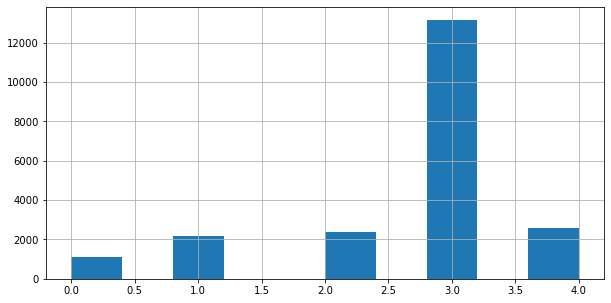

In [8]:
train_df['label'].hist(figsize = (10, 5))


In this case, we have 5 labels (4 diseases and healthy):
0. Cassava Bacterial Blight (CBB)
1. Cassava Brown Streak Disease (CBSD)
2. Cassava Green Mottle (CGM)
3. Cassava Mosaic Disease (CMD)
4. Healthy

In this case label 3, [Cassava Mosaic Disease (CMD)](https://en.wikipedia.org/wiki/Cassava_mosaic_virus) is the most common label. This imbalance may have to be addressed with a weighted loss function or oversampling. I might try this in a future iteration of this kernel or in a new kernel.

Let's check an example image to see what it looks like:

In [9]:
from PIL import Image

im = Image.open(train_df['path'][1])
width, height = im.size
print(width,height) 

800 600


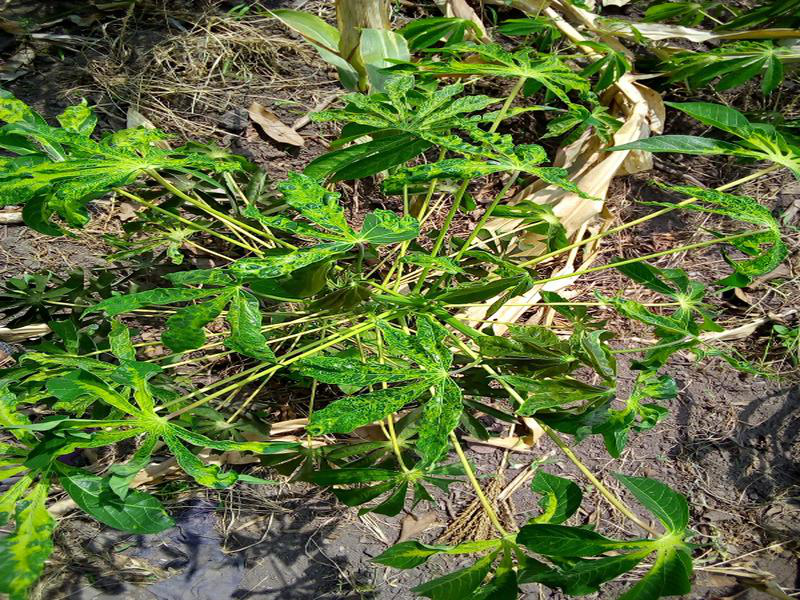

In [10]:
im

## Data loading

After my quick 'n dirty EDA, let's load the data into fastai as `DataLoaders` objects. 

First let's define item and batch transforms. The item transforms performs a fairly large crop on each of the images, while the batch transforms performs random resized crop to 224 and also apply other standard augmentations (in `aug_tranforms`) at the batch level on the GPU. The batch size is set to 256 here.


In [11]:
item_tfms = RandomResizedCrop(460, min_scale=0.75, ratio=(1.,1.))
batch_tfms = [*aug_transforms(size=224, max_warp=0), Normalize.from_stats(*imagenet_stats)]
bs=256

While fastai provides various ways of doing custom dataloading (even just taking plain PyTorch DataLoaders), traditional image classification problems work well the high-level data API. Here, we can pass all the required info to create an `DataLoaders` object.

In [12]:
dls = ImageDataLoaders.from_df(train_df, #pass in train DataFrame
                               valid_pct=0.2, #80-20 train-validation random split
                               seed=999, #seed
                               label_col=0, #label is in the first column of the DataFrame
                               fn_col=1, #filename/path is in the second column of the DataFrame
                               bs=bs, #pass in batch size
                               item_tfms=item_tfms, #pass in item_tfms
                               batch_tfms=batch_tfms) #pass in batch_tfms

To confirm successful dataloader creation, we can use the `show_batch` command, which shows a subset of the batch:

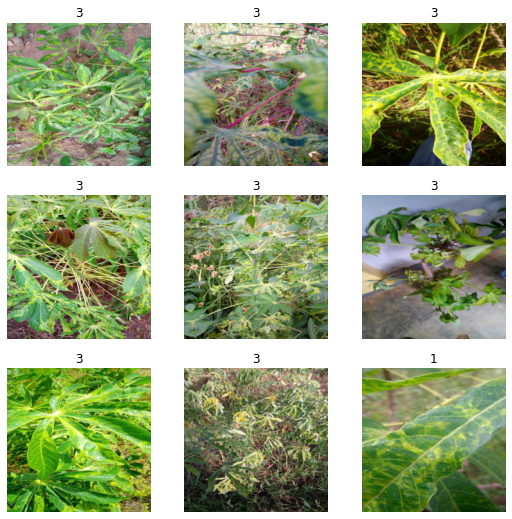

In [13]:
dls.show_batch()

## Model training:

Let's train a simple ResNet50 model. Since this competition doesn't allow internet access, I have added the pretrained ResNet50 weights as a dataset, and the below code cell will allow PyTorch/fastai to find the file:

In [14]:
# Making pretrained weights work without needing to find the default filename
if not os.path.exists('/root/.cache/torch/hub/checkpoints/'):
        os.makedirs('/root/.cache/torch/hub/checkpoints/')
!cp '../input/resnet50/resnet50.pth' '/root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth'

When training CNN models, we can use the `cnn_learner` function which creates a `Learner` object that allows us to train a provided model with the given dataloaders. We will also use common state-of-the-art training techniques like mixup and label smoothing, which are provided in fastai. We can also use mixed precision very easily:

In [15]:
learn = cnn_learner(dls, 
                    resnet50, 
                    loss_func = LabelSmoothingCrossEntropy(), 
                    metrics = [accuracy], 
                    cbs=MixUp()).to_native_fp16()

In order to train a model, we need to find the most optimal learning rate, which can be done with fastai's learning rate finder:

SuggestedLRs(lr_min=0.012022644281387329, lr_steep=0.019054606556892395)

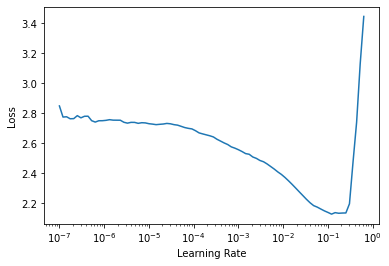

In [16]:
learn.lr_find()

The optimal learning rate is where the loss is decreasing most rapidly: around ~1e-2. 

Let's start training the model. Often, the best way to train a model is to train the frozen pretrained model for a single epoch (using one-cycle training), then train the whole pretrained model for several epochs using one-cycle training. This can be done using `learn.fine_tune`. We simple need to provide the learning rate for the one-cycle schedule and the number of epochs to train the unfrozen model:

In [17]:
learn.fine_tune(5,base_lr=1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,1.486595,0.994988,0.705305,05:55


epoch,train_loss,valid_loss,accuracy,time
0,1.035104,1.147087,0.815611,06:01
1,0.972385,0.755687,0.828231,05:58
2,0.914733,0.905507,0.842487,06:03
3,0.871208,0.711749,0.857210,06:03
4,0.836071,0.699724,0.862117,06:01


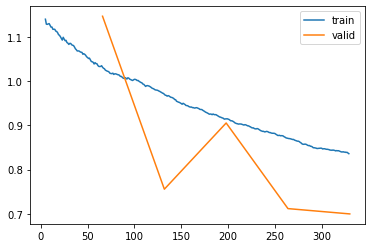

In [18]:
learn.recorder.plot_loss()

In [19]:
learn.remove_cbs([MixUp])

In [20]:
learn = learn.to_native_fp32()

We plotted the loss, put the model back to fp32, and now we can export the model if we want to use later (i.e. for an inference kernel):

In [21]:
learn.export()

fastai also comes with some additional utilities like checking the confusion matrix: 

In [22]:
interp = ClassificationInterpretation.from_learner(learn)

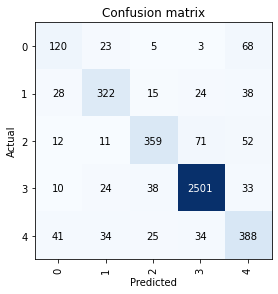

In [23]:
interp.plot_confusion_matrix()

## Inference

It's very simple to perform inference with fastai. The `dls.test_dl` function allows you to create test dataloader using the same pipeline defined earlier.

In [24]:
sample_df = pd.read_csv(dataset_path/'sample_submission.csv')
sample_df.head()

,image_id,label
0,2216849948.jpg,4


In [25]:
_sample_df = sample_df.copy()
_sample_df['path'] = _sample_df['image_id'].map(lambda x:dataset_path/'test_images'/x)
_sample_df = _sample_df.drop(columns=['image_id'])
test_dl = dls.test_dl(_sample_df)

We can easily confirm that the test_dl is correct:

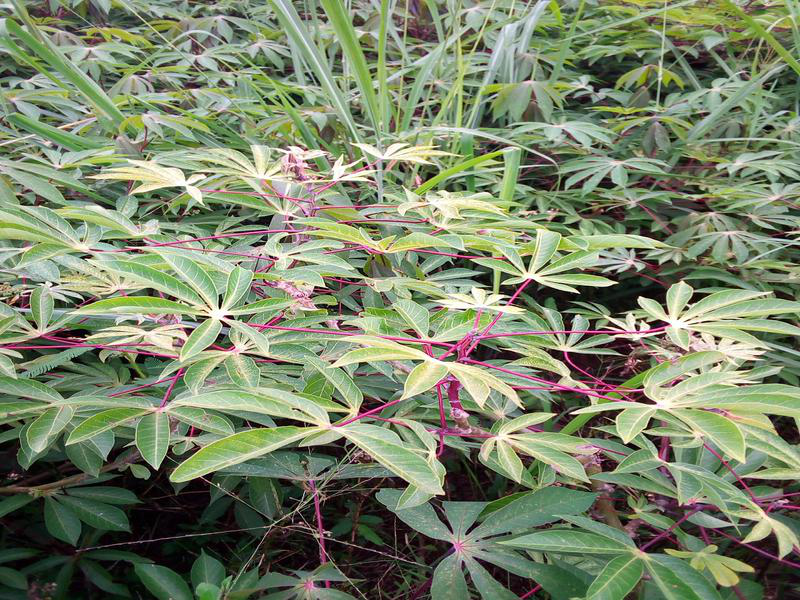

In [26]:
test_dl.dataset[0][0]

Now let's pass the dataloader to the model and get predictions:

In [27]:
preds, _ = learn.get_preds(dl=test_dl)

Let's make a submission with these predictions!

In [28]:
sample_df['label'] = preds.argmax(dim=-1).numpy()

In [29]:
sample_df.to_csv('submission.csv',index=False)

Now, **WE ARE DONE**!

If you enjoyed this kernel, please give it an upvote. If you have any questions or suggestions, please leave a comment!